# TIER 1 MODEL NOTEBOOK

# Purpose: Train HABNet CNN+LSTM model using 3 modalities, 10 days 

## Imports

In [36]:

import random
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [37]:
random.seed(10)
print(random.random())  # ➝ 0.5714025946899135

random.seed(42)
print(random.random())  # ➝ 0.6394267984578837


0.5714025946899135
0.6394267984578837


##  Config for tier-1 

In [39]:


MODALITIES = 3
DAYS = 10
IMG_SIZE = (64, 64)
DATA_DIR = "/kaggle/input/hab-200/dataset_200"


## Load Function

In [40]:

def load_data_habnet_only():
    X_raw, y = [], []
    for label in ["0", "1"]:
        label_path = os.path.join(DATA_DIR, label)
        for sample_id in os.listdir(label_path):
            sample_path = os.path.join(label_path, sample_id)
            modalities = sorted(os.listdir(sample_path))[:MODALITIES]
            cube = []

            for mod in modalities:
                mod_path = os.path.join(sample_path, mod)
                day_images = []
                for d in range(1, DAYS + 1):
                    img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
                    if os.path.exists(img_path):
                        img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                        img_np = np.array(img)
                        day_images.append(img_np)

                if len(day_images) == DAYS:
                    cube.append(day_images)

            if len(cube) == MODALITIES:
                cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
                X_raw.append(cube_np)
                y.append(int(label))

    return np.array(X_raw), np.array(y)





 # HABNet MODEL TRAINING 

In [41]:

def train_habnet():
    X_raw, y = load_data_habnet_only()
    print(" Data shape:", X_raw.shape, y.shape)

    y_cat = to_categorical(y, num_classes=2)

    X_train, X_temp, y_train, y_temp = train_test_split(X_raw, y_cat, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    input_shape = (X_raw.shape[1], X_raw.shape[2], X_raw.shape[3], X_raw.shape[4])
    inputs = Input(shape=input_shape)

    x = Conv3D(32, (3, 3, 3), activation='relu')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(64, (3, 3, 3), activation='relu')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print(" Starting Training...")
    start = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
    end = time.time()
    print("\n Time taken:", round(end - start, 2), "seconds")

    print("\n Evaluation on Test Set:")
    loss, acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", acc)

    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("HABNet Confusion Matrix")
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("HABNet Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

#  RUN TRAINING 


 Data shape: (400, 10, 64, 64, 3) (400,)
 Starting Training...
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5832 - loss: 16.4187 - val_accuracy: 0.7333 - val_loss: 2.1557
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6900 - loss: 4.8177 - val_accuracy: 0.8833 - val_loss: 0.8538
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8741 - loss: 0.8459 - val_accuracy: 0.8667 - val_loss: 0.5622
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8476 - loss: 0.4383 - val_accuracy: 0.8667 - val_loss: 0.4214
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9303 - loss: 0.2283 - val_accuracy: 0.9167 - val_loss: 0.3831
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9050 - loss: 0.2155 - val_accuracy: 0.9000 - val_loss: 0.4693
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9182 - loss: 0.1919 - val_accuracy: 0.9167 - val_loss: 0.5006
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - ac

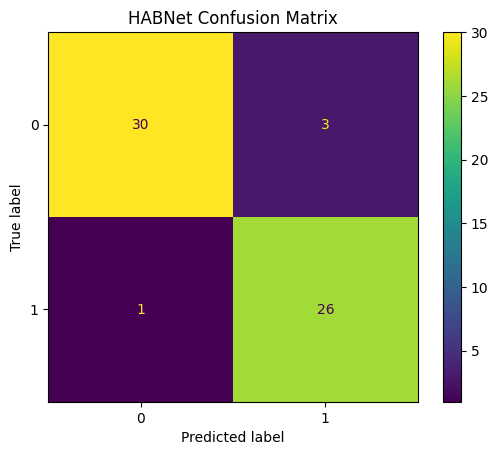

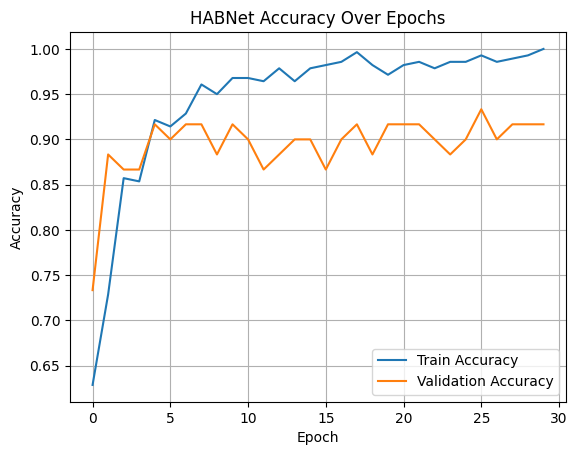

In [42]:
train_habnet()